![Alt text: Slogan da Meteora.](https://i.imgur.com/VDYh2G1.png)

# 1. Estruturando a tabela

**Meteora** é uma loja que vende roupas e acessórios de diversas marcas por todos os estados do Brasil, para entender suas bases de dados e exibir informações relevantes com o objetivo de auxiliar suas tomadas de decisão.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, inspect, text

**Sobre as tabelas**

* itens_pedidos: tabela que informa sobre o que foi vendido, vai ter informação o preço, quantidade, para onde vai ser enviado e o frete do pedido
* pedidos: vai falar sobre a venda feita, tendo informação sobre os vendedores, preço do pedido e a data da venda
* produtos: informa características dos produtos que são comercializados na loja
* vendedores: informa o nome dos vendedores.

In [5]:
url_itens_pedidos = 'https://github.com/lukaswyllis/formacao-avancando-em-data-science-com-python/raw/refs/heads/master/dados-curso6/itens_pedidos.csv'
url_pedidos = 'https://github.com/lukaswyllis/formacao-avancando-em-data-science-com-python/raw/refs/heads/master/dados-curso6/pedidos.csv'
url_produtos = 'https://github.com/lukaswyllis/formacao-avancando-em-data-science-com-python/raw/refs/heads/master/dados-curso6/produtos.csv'
url_vendedores = 'https://github.com/lukaswyllis/formacao-avancando-em-data-science-com-python/raw/refs/heads/master/dados-curso6/vendedores.csv'

In [38]:
COR_METEORA = '#9353FF'

In [6]:
itens_pedidos = pd.read_csv(url_itens_pedidos)
pedidos = pd.read_csv(url_pedidos)
produtos = pd.read_csv(url_produtos)
vendedores = pd.read_csv(url_vendedores)

In [7]:
engine = create_engine('sqlite:///:memory:')

In [11]:
itens_pedidos.to_sql('itens_pedidos', engine, index=False)
pedidos.to_sql('pedidos', engine, index=False)
produtos.to_sql('produtos', engine, index=False)
vendedores.to_sql('vendedores', engine, index=False)

5

In [56]:
inspector = inspect(engine)
print(inspector.get_table_names())

['itens_pedidos', 'pedidos', 'produtos', 'vendedores']


# 2. Primeiras consultas

Vamos entender a característica do produto que é comercializadora na Meteora, analisando a **condição** dos produtos vendidos.

In [13]:
query = 'SELECT CONDICAO FROM PRODUTOS'

In [14]:
with engine.connect() as conexao:
  consulta = conexao.execute(text(query))
  dados = consulta.fetchall()

pd.DataFrame(dados, columns=consulta.keys())

,Condicao
0,Usado
1,Usado
2,Usado
3,Usado
4,Usado
...,...
200,Usado
201,Usado
202,Usado
203,Usado


In [15]:
def sql_df(query):
  with engine.connect() as conexao:
    consulta = conexao.execute(text(query))
    dados = consulta.fetchall()
  return pd.DataFrame(dados, columns=consulta.keys())

In [20]:
query = '''

SELECT CONDICAO, COUNT(*) AS Quantidade
FROM PRODUTOS
GROUP BY CONDICAO

'''

Agora precisamos ranquear os produtos que mais foram pedidos por **quantidade** para entender a necessidade de um estoque de produtos na loja.

In [21]:
df_produtos = sql_df(query)
df_produtos

,Condicao,Quantidade
0,Novo com etiqueta,22
1,Novo sem etiqueta,7
2,Usado,176


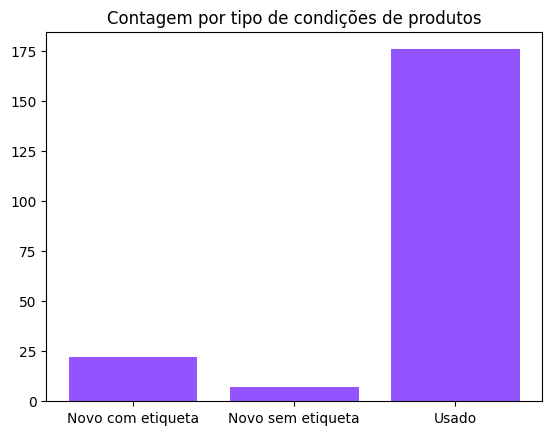

In [23]:
plt.bar(df_produtos['Condicao'], df_produtos['Quantidade'], color='#9353FF')
plt.title('Contagem por tipo de condições de produtos')
plt.show()

In [24]:
sql_df('SELECT * FROM PRODUTOS').head(3)

,produto_id,produto,preco,marca,sku,Condicao
0,21244,Oculos Lente Azulada,1120,D&g Dolce & Gabbana,209297,Usado
1,9981,Bolsa Coral Saco,4000,Givenchy,278612,Usado
2,84176,Camisa Xadrez Verde,310,Joe Fresh,322482,Usado


In [25]:
sql_df('SELECT * FROM ITENS_PEDIDOS').head(3)

,id_nf,produto_id,pedido_id,quantidade,valor_unitario,valor_total,Estado,frete
0,1,41518,341,3,260,780,BR-BA,156.0
1,2,4307,1174,5,6175,30875,BR-RJ,6175.0
2,3,22407,1399,3,200,600,BR-PB,120.0


In [35]:
query = '''

SELECT PRODUTOS.produto, SUM(ITENS_PEDIDOS.quantidade) as Quantidade
FROM ITENS_PEDIDOS, PRODUTOS
WHERE ITENS_PEDIDOS.produto_id = PRODUTOS.produto_id
GROUP BY PRODUTOS.PRODUTO
ORDER BY Quantidade DESC

'''

In [41]:
df_prod_quant = sql_df(query).head(10).sort_values('Quantidade')
df_prod_quant

,produto,Quantidade
9,Bomber Tricot Off,507
8,Cropped Escritas Pb,508
7,Camisa Xadrez Azul,511
6,Blusa Manga Estampa,536
5,Vestido Nude Reta,547
4,Saia Midi Cinto,549
3,Calca Alfaiataria Preta,750
2,Saia Pregas Preta,751
1,Calca Jeans Costuras,755
0,Vestido Recortes Cores,795


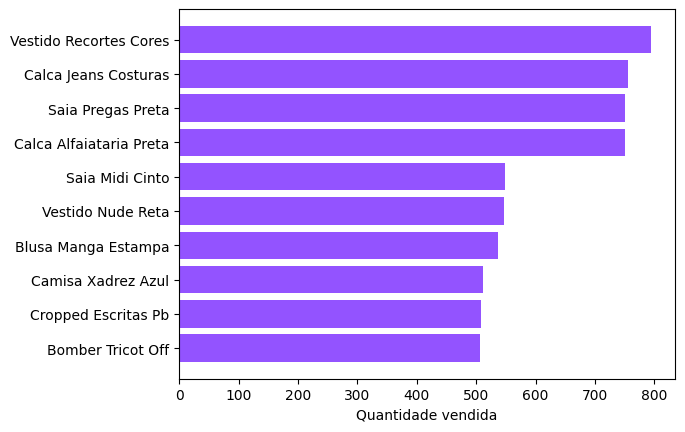

In [42]:
plt.barh(df_prod_quant['produto'], df_prod_quant['Quantidade'], color=COR_METEORA, )
plt.xlabel('Quantidade vendida')
plt.show()

# 3. Lidando com filtro

Vamos iniciar uma análise de desempenho do **time de vendedores** da Meteora. A intenção aqui é entender como se deram as vendas dos vendedores no **ano anterior** para que possam ser aplicadas promoções e bônus salarial para a equipe no ano atual da tabela que é 2021

In [46]:
sql_df('select * from pedidos').head()

,pedido_id,produto_id,vendedor_id,data_compra,total
0,341,41518,5,2019-01-05,780
1,1174,4307,3,2019-01-05,30875
2,1399,22407,1,2019-01-05,600
3,1652,3820,4,2019-01-05,834
4,2470,29012,2,2019-01-05,1575


In [47]:
sql_df('select * from pedidos').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24527 entries, 0 to 24526
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   pedido_id    24527 non-null  int64 
 1   produto_id   24527 non-null  int64 
 2   vendedor_id  24527 non-null  int64 
 3   data_compra  24527 non-null  object
 4   total        24527 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 958.2+ KB


Para entender o desempenho de vendas dos vendedores no ano de 2020, é preciso trabalhar com os dados que estão presentes apenas no ano de 2020.

In [61]:
query = '''

select vendedores.nome_vendedor as Vendedor, avg(pedidos.total) as Média
from vendedores, pedidos
where strftime('%Y', data_compra) = '2020' and vendedores.vendedor_id = pedidos.vendedor_id
group by Vendedor
order by Média desc;
'''
sql_df(query)

,Vendedor,Média
0,Daniel Siqueira,1972.338526
1,Millena Pereira,1894.614343
2,Ana Duarte,1843.452582
3,Nadia Oliveira,1818.342200
4,Paulo Calanca,1813.469855


# 4. Avançando nas relações

A Meteora agora deseja incrementar as suas vendas no **estado de São Paulo (SP)**, por acreditar ser uma região mais propícia às vendas já que tem uma boa concentração de pessoas e mercado também.

Mas será que São Paulo já não rende muitas vendas em relação a outros estados?

In [63]:
query = '''

select estado, count(*) as qtd
from itens_pedidos
group by estado
order by qtd desc

'''
sql_df(query)

,Estado,qtd
0,BR-MA,974
1,BR-DF,953
2,BR-MT,937
3,BR-GO,933
4,BR-PA,932
5,BR-AL,928
6,BR-PE,927
7,BR-RR,925
8,BR-RO,925
9,BR-RN,921


Uma das ações que a Meteora pretende seguir para as vendas em SP é escolher dois de seus vendedores para que eles **foquem suas vendas** lá. Para essa escolha é interessante ter os profissionais que **mais tenham vendido** para as pessoas da região.

In [69]:
query = '''

select vendedores.nome_vendedor, count(*) as qtd
from pedidos
join vendedores on vendedores.vendedor_id = pedidos.vendedor_id
join itens_pedidos on pedidos.pedido_id = itens_pedidos.pedido_id
where itens_pedidos.estado = 'BR-SP'
group by vendedores.nome_vendedor
order by qtd desc

'''
sql_df(query)

,nome_vendedor,qtd
0,Daniel Siqueira,190
1,Paulo Calanca,182
2,Nadia Oliveira,181
3,Ana Duarte,180
4,Millena Pereira,157
